## TP2

Équipe n°3
* Ala Antabli (anta2801)
* Josselin Dubois (dubj0701)
* Antoine Guénard (guea0702)
* Gurleen Padda (padg5000)


### Mise en place de l'environnement

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

### Chargement des données

In [2]:
order_products_prior_specials = pd.read_csv("données/order_products__prior_specials.csv")
order_distance_stores_softmax = pd.read_csv("données/orders_distance_stores_softmax.csv")

In [3]:
merged_order = pd.merge(order_products_prior_specials, order_distance_stores_softmax, on="order_id")
merged_order = merged_order.dropna()

print(merged_order.nunique())
merged_order = merged_order.drop("eval_set", 1)  # car une seule valeur

merged_order.to_csv("données/merged_order.csv")

Unnamed: 0_x              1158441
order_id                   134652
product_id                  24783
add_to_cart_order              98
reordered                       2
special                         4
Unnamed: 0_y               134652
user_id                      1374
store_id                       10
distance                    13736
eval_set                        1
order_number                   98
order_dow                       7
order_hour_of_day              24
days_since_prior_order         31
dtype: int64


C:\Users\Josse\AppData\Local\Temp\ipykernel_55152\2812134702.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  merged_order = merged_order.drop("eval_set", 1)  # car une seule valeur


### Suppression de données

On sélectionne 5% des utilisateurs de façon aléatoire 

In [4]:
all_users = merged_order["user_id"].unique()
nb_users = len(all_users)
reduced_nb_users = nb_users * 5 // 100

restricted_users = np.random.choice(all_users, size=reduced_nb_users)
restricted_order = merged_order.loc[merged_order["user_id"].isin(restricted_users)]
restricted_order.drop(labels=["Unnamed: 0_x", "Unnamed: 0_y"], axis=1)

restricted_order.to_csv("données/clean_data.csv")

In [5]:
def z_score(sample, data):
    return abs(sample.mean()-data.mean())/data.std()
z_score(restricted_order, merged_order)

Unnamed: 0_x              0.007719
order_id                  0.007736
product_id                0.002273
add_to_cart_order         0.036053
reordered                 0.019457
special                   0.012865
Unnamed: 0_y              0.238289
user_id                   0.237112
store_id                  0.012563
distance                  0.024059
order_number              0.005274
order_dow                 0.050706
order_hour_of_day         0.009860
days_since_prior_order    0.024110
dtype: float64

Les moyennes des données échantillonnées se retrouvent à moins d'un écart-type des moyennes de l'ensemble de données complet, ce qui veut dire que les données échantillonnées reflètent la distribution de l'ensemble de données complet.

### Séparation des données

In [6]:
test_prop = 0.2
train_df, test_df = train_test_split(restricted_order, test_size=test_prop)

full_train_df = train_df.copy()
full_train_df['set'] = "train"

full_test_df = test_df.copy()
full_test_df['set'] = "test"

full_df = full_train_df.append(full_test_df)
full_df.head()

,Unnamed: 0_x,order_id,product_id,add_to_cart_order,reordered,special,Unnamed: 0_y,user_id,store_id,distance,order_number,order_dow,order_hour_of_day,days_since_prior_order,set
744898,744898,2173329,16797,5,1,0,42327,62772,5,0.177761,22,2,15,2.0,train
204202,204202,597491,35535,10,1,0,102135,154556,5,1.525185,96,0,16,4.0,train
1092195,1092195,3187361,19180,1,1,0,17070,22767,4,1.190270,22,5,15,7.0,train
404780,404780,1183815,49683,4,1,0,105311,160297,5,0.791967,90,1,20,6.0,train
773145,773145,2254079,19248,18,1,30,4222,5449,6,1.070162,63,6,17,0.0,train


In [7]:
z_score(train_df, merged_order)

Unnamed: 0_x              0.006193
order_id                  0.006214
product_id                0.000435
add_to_cart_order         0.032923
reordered                 0.019696
special                   0.011431
Unnamed: 0_y              0.238676
user_id                   0.237528
store_id                  0.010180
distance                  0.024699
order_number              0.005283
order_dow                 0.049648
order_hour_of_day         0.007803
days_since_prior_order    0.023067
dtype: float64

In [8]:
z_score(test_df, merged_order)

Unnamed: 0_x              0.013820
order_id                  0.013823
product_id                0.009626
add_to_cart_order         0.048573
reordered                 0.018500
special                   0.018601
Unnamed: 0_y              0.236741
user_id                   0.235448
store_id                  0.022092
distance                  0.021498
order_number              0.005236
order_dow                 0.054938
order_hour_of_day         0.018086
days_since_prior_order    0.028280
dtype: float64

Les moyennes des données train et test se retrouvent à moins d'un écart-type des moyennes de l'ensemble de données complet, ce qui veut dire que les données échantillonnées reflètent la distribution de l'ensemble de données complet.

### Visualisation des données

In [9]:
# full_df.columns

# useful_columns = ["user_id", "add_to_cart_order", "reordered", "distance", "order_dow", "order_hour_of_day", "days_since_prior_order", "set"]

# fig = plt.figure(figsize=(10, 10))

# g = sns.PairGrid(full_df[useful_columns], hue="set")
# g.map_diag(sns.histplot)
# g.map_offdiag(sns.scatterplot)
# g.add_legend();


<AxesSubplot:>

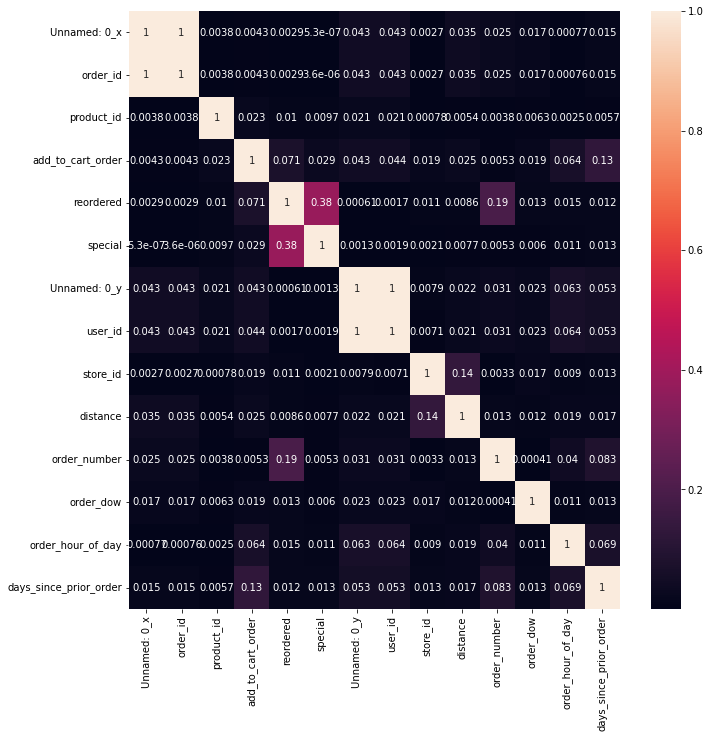

In [10]:
data_corr = restricted_order.corr()
plt.figure(figsize = (11,11))
sns.heatmap(abs(data_corr), annot = True)

### CNN

In [11]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

train_x = train_df.loc[:, train_df.columns != "reordered"]
train_y = train_df["reordered"]

test_x = test_df.loc[:, test_df.columns != "reordered"]
test_y = test_df["reordered"]

layers = [
    (i, j)
    for i in [5, 10, 25, 50, 100]
    for j in [5, 10, 25, 50, 100]
]

params = {
    "hidden_layer_sizes": layers,
    "activation": ["relu"]
}


clf = MLPClassifier(hidden_layer_sizes=(50, 50), activation="relu")
clf.out_activation_ = 'softmax'

clf_hp = GridSearchCV(clf, param_grid=params)
clf_hp.fit(X=train_x, y=train_y)

GridSearchCV(estimator=MLPClassifier(hidden_layer_sizes=(50, 50)),
             param_grid={'activation': ['relu'],
                         'hidden_layer_sizes': [(100, 100)]})

In [12]:
from sklearn.metrics import confusion_matrix


best_params = clf_hp.best_params_
pred = clf_hp.predict(test_x)

tn, fp, fn, tp = confusion_matrix(y_true=test_y, y_pred=pred).ravel()

precision = tp / (tp + fp)
recall = tp / (tp + fn)

F1 = (2 * precision * recall) / (precision + recall)

In [13]:
print(best_params)
print(F1)

{'activation': 'relu', 'hidden_layer_sizes': (100, 100)}
0.8717264044366849


Le score F1 est assez élevé, ce qui démontre une bonne performance de notre modèle (une bonne précision et une bonne capacité à trouver les positifs)

### Visualisation des produits fréquemment commandés ensemble

In [79]:
products_from_same_orders = {}


for order_id in train_df["order_id"].unique():

    order_df = train_df.loc[train_df["order_id"] == order_id]
    order_products = order_df["product_id"].unique()

    for i in range(len(order_products)):
        product_id = order_products[i]

        if product_id not in products_from_same_orders:
            products_from_same_orders[product_id] = {}

        for j in range(i+1, len(order_products)):
            other_product_id = order_products[j]

            if other_product_id in products_from_same_orders[product_id]:
                products_from_same_orders[product_id][other_product_id] += 1
            else:
                products_from_same_orders[product_id][other_product_id] = 1

In [80]:
products = pd.read_csv("données/products.csv").drop(labels=["aisle_id", "department_id"], axis=1)
products.head()

,product_id,product_name
0,1,Chocolate Sandwich Cookies
1,2,All-Seasons Salt
2,3,Robust Golden Unsweetened Oolong Tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...
4,5,Green Chile Anytime Sauce


In [81]:
min_number_of_same_orders = 25
frequently_products = {}
frequently_labels = []
added_products = []

for product_id in products_from_same_orders.keys():

    all_values = set(products_from_same_orders[product_id].values())


    best_values = list(filter(
        lambda occ: occ > min_number_of_same_orders,   
        all_values
    ))

    best_keys = list(filter(
        lambda other_id: products_from_same_orders[product_id][other_id] in best_values,
        products_from_same_orders[product_id]
    ))

    if len(best_keys) > 0:
        
        product_label = products.loc[products['product_id'] == product_id].iloc[0]['product_name']
        frequently_labels.append(product_label)

        if product_id not in added_products:
            added_products.append(product_id)

        for other_id in best_keys:
            if other_id not in added_products:
                added_products.append(other_id)

        frequently_products[product_id] = best_keys


frequently_products = {
    added_products.index(key): [added_products.index(v) for v in value]
    for key, value in frequently_products.items()
}

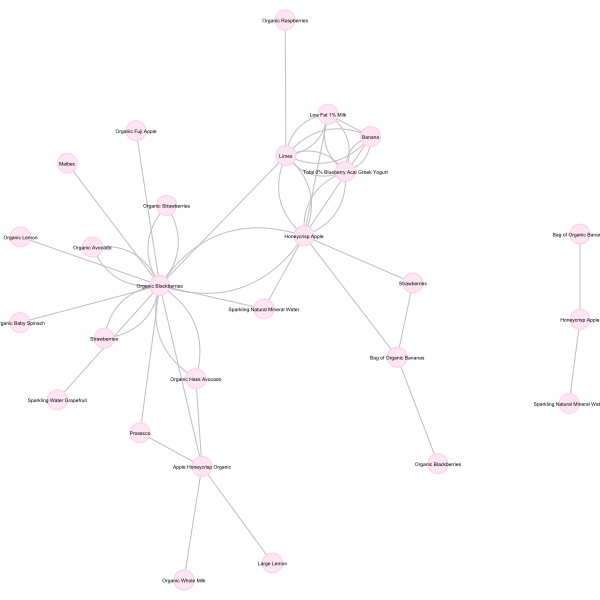

In [77]:
import igraph as ig

g = ig.Graph(edges= [(v, a) for v in list(frequently_products.keys()) for a in frequently_products[v]])

g.vs["label"] = frequently_labels
for i in range(len(g.vs["label"])):
    g.vs[i]["label_size"] = 5

ig.plot(
    g,
    vertex_size=20,
    vertex_label=frequently_labels,
    vertex_frame_color='#ffcce6',
    edge_color=["gray"],
    vertex_color=["#ffe6f2"],
    target="graph.png"
)

### Conclusion

a) Selon la matrice de corrélation, il existe une faible corrélation entre le fait qu'un produit soit en promotion et qu'il soit re-commandé. La correlation entre les variables `reordered` et `order_id` provient probablement du fait que pour les premières commandes enregistrées, la variable `reordered` doit être 0 par défaut parce qu'il n'y a pas de données précedentes pour verifier si le produit a déja été commandé par l'utilisateur. Sinon il n'y a pas d'autres corrélations significatives dans les données.

On peut voir sur le graphe les produits fréquemment commandés ensemble (dans plus de 25 commandes).

b) Les hyperparamètres sont le nombre de couches internes (2), les fonctions d'activation (relu et softmax), et les dimensions des couches internes (100 et 100 après notre recherche d'hyperparamètres).  

c) Selon le score F1, qui est proche de 1, le choix de modèle était judicieux. Contrairement à un modèle k-nn, ce modèle ne passe pas par toutes les données d'apprentissage pour effectuer une classification, ce qui est plus efficace compte tenu de la taille de l'ensemble de données. De plus, les CNN peuvent modéliser n'importe quelle fonction continue contrairement à d'autres modèle, ce qui est utile dans ce cas car il n'y avait pas de corrélation évidente dans les données pour nous guider vers un autre modèle.

d) Le score F1 est proche de 1 ce qui nous indique que la `precision` et le `recall` doivent aussi être proche de 1. Donc il y a eu beaucoup plus de vrai positifs que de faux positifs ou faux negatifs. Cela nous indique que le modèle fonctionne bien sur les cas positifs (reordered = 1), ce qui est justement ce qui nous intéresse.
